## Carga e Importacion

In [ ]:
%%capture
!pip install fiftyone
!pip install chromadb
!pip install --upgrade ultralytics
!pip install --upgradetorch

In [ ]:
# Manipulacion de imagenes
from PIL import Image, ImageDraw
import numpy as np
import cv2
import PIL
from PIL import Image, ImageDraw, ImageFont

# Analisis y Visualizacion
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

# Frameworks de Computer Vision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from ultralytics import YOLO
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
import fiftyone.utils.torch as fout


# Bases de datos y almacenamiento
import chromadb
import pickle
import kagglehub

# Utilidades generales.
import requests
from io import BytesIO
import os
from collections import Counter
import math
import tempfile
from tqdm import tqdm

In [ ]:
# Hay veces que fiftyone da error abajo creando los dataset y hay que tocar esto
#!fiftyone app launch

In [ ]:
# Descargamos el Dataset a utilizar
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")


print("Path to dataset files:", path)

100%|██████████| 215M/215M [00:02<00:00, 81.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2


In [ ]:
path # nos queda descargado en una carpeta que tenemos que acceder haciendo ..

'/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2'

In [ ]:
# Cargamos ResNet50 de imagenet con fiftyone zoo

foz.list_zoo_models()

['alexnet-imagenet-torch',
 'centernet-hg104-1024-coco-tf2',
 'centernet-hg104-512-coco-tf2',
 'centernet-mobilenet-v2-fpn-512-coco-tf2',
 'centernet-resnet101-v1-fpn-512-coco-tf2',
 'centernet-resnet50-v1-fpn-512-coco-tf2',
 'centernet-resnet50-v2-512-coco-tf2',
 'classification-transformer-torch',
 'clip-vit-base32-torch',
 'deeplabv3-cityscapes-tf',
 'deeplabv3-mnv2-cityscapes-tf',
 'deeplabv3-resnet101-coco-torch',
 'deeplabv3-resnet50-coco-torch',
 'densenet121-imagenet-torch',
 'densenet161-imagenet-torch',
 'densenet169-imagenet-torch',
 'densenet201-imagenet-torch',
 'depth-estimation-transformer-torch',
 'detection-transformer-torch',
 'dinov2-vitb14-reg-torch',
 'dinov2-vitb14-torch',
 'dinov2-vitg14-reg-torch',
 'dinov2-vitg14-torch',
 'dinov2-vitl14-reg-torch',
 'dinov2-vitl14-torch',
 'dinov2-vits14-reg-torch',
 'dinov2-vits14-torch',
 'efficientdet-d0-512-coco-tf2',
 'efficientdet-d0-coco-tf1',
 'efficientdet-d1-640-coco-tf2',
 'efficientdet-d1-coco-tf1',
 'efficientdet-d

In [ ]:
modelo_preentrenado = foz.load_zoo_model('resnext50-32x4d-imagenet-torch')

INFO:fiftyone.core.models:Downloading model from 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth'...


 100% |████|  766.3Mb/766.3Mb [2.1s elapsed, 0s remaining, 468.4Mb/s]      


INFO:eta.core.utils: 100% |████|  766.3Mb/766.3Mb [2.1s elapsed, 0s remaining, 468.4Mb/s]      
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 55.4MB/s]


In [ ]:
df = pd.read_csv(path + '/dogs.csv')

## Analisis exploratorio

In [ ]:
df

filepaths  labels data set
0     train/Afghan/001.jpg  Afghan    train
1     train/Afghan/002.jpg  Afghan    train
2     train/Afghan/003.jpg  Afghan    train
3     train/Afghan/004.jpg  Afghan    train
4     train/Afghan/005.jpg  Afghan    train
...                    ...     ...      ...
9341   valid/Yorkie/06.jpg  Yorkie    valid
9342   valid/Yorkie/07.jpg  Yorkie    valid
9343   valid/Yorkie/08.jpg  Yorkie    valid
9344   valid/Yorkie/09.jpg  Yorkie    valid
9345   valid/Yorkie/10.jpg  Yorkie    valid

[9346 rows x 3 columns]

El dataset contiene 3 columnas. Una que nos dice donde esta el path hacia la imagen, otra el label de la raza (que se podria inferir por el path) y otra a cual split pertence

In [ ]:
df['data set'].value_counts()

data set
train    7946
test      700
valid     700
Name: count, dtype: int64

Hay 7946 datos de train y 1400 entre test y validacion. Veamos si hay algun valor faltante

In [ ]:
df.isna().sum()

filepaths    0
labels       0
data set     0
dtype: int64

Al no haber valores faltantes veamos que cantidad de perros hay por raza

In [ ]:
df.groupby('labels').count().sort_values(by='data set', ascending=True)

filepaths  data set
labels                                
American  Spaniel         10        10
American Hairless         85        85
Newfoundland              98        98
Saint Bernard             98        98
Yorkie                    98        98
...                      ...       ...
Scotch Terrier           170       170
Basset                   179       179
Labrador                 181       181
Lhasa                    207       207
Shih-Tzu                 218       218

[71 rows x 2 columns]

Decido dropear los American Spaniel debido a que hay muy pocas observaciones y va a causar problemas.

In [ ]:
df.drop(df[df['labels'] == 'American Spaniel'].index, inplace=True)

## Creación de Dataset FiftyOne y embedding de imagenes

In [ ]:
# Esto solo se corre si se quiere borrar los dataset creados
fo_ds_names = fo.list_datasets()

for fo_ds_name in fo_ds_names:
  fo.delete_dataset(fo_ds_name)

In [ ]:
%%capture
samples = []

# Iteramos por el dataframe para crear samples de fiftyone
for _, row in df.iterrows():
    sample = fo.Sample(
        filepath=path + '/' + row['filepaths'],
        ground_truth=fo.Classification(label=row['labels']),
        tags=[row['data set']]
    )
    samples.append(sample)

# Creamos el dataset con todos los datos
dataset = fo.Dataset('dataset_completo')
dataset.add_samples(samples)

 100% |███████████████| 9247/9247 [6.7s elapsed, 0s remaining, 2.0K samples/s]        


INFO:eta.core.utils: 100% |███████████████| 9247/9247 [6.7s elapsed, 0s remaining, 2.0K samples/s]        


In [ ]:
# Checkeamos que no haya duplicados
duplicates_map = fob.compute_exact_duplicates(dataset)

Computing filehashes...


INFO:fiftyone.brain.internal.core.duplicates:Computing filehashes...


 100% |███████████████| 9247/9247 [413.1ms elapsed, 0s remaining, 22.4K samples/s]      


INFO:eta.core.utils: 100% |███████████████| 9247/9247 [413.1ms elapsed, 0s remaining, 22.4K samples/s]      


In [ ]:
len(duplicates_map) # Hay al menos 105 duplicados (es un dicionario, puede haber mas de uno por id)

105

Pareciera haber muchos duplicados, vamos a borrarlos asi mantenemos consistencia en los siguientes pasos

In [ ]:
# Si los hay, borramos
for group in duplicates_map.values():
  dataset.delete_samples(group)

Obtenido un dataset "limpio", procedemos a computar los embeddings

In [ ]:
dataset.compute_embeddings(model=modelo_preentrenado, embeddings_field="image_embeddings")

 100% |███████████████| 9128/9128 [2.7m elapsed, 0s remaining, 57.7 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 9128/9128 [2.7m elapsed, 0s remaining, 57.7 samples/s]       


## Visualizacion leaks


Como fue visto en la materia, se puede verificar leak de datos en los splits mediantes las siguientes lineas

In [ ]:
split_tags = ["train", "test", "valid"]
index = fob.compute_leaky_splits(dataset, splits=split_tags, embeddings="image_embeddings")

In [ ]:
leaks = index.leaks_view()

In [ ]:
session = fo.launch_app(leaks)

Parece que hay algunos leaks. Algunos son fotos obtenidas a traves de augmentation porque se las nota levemente corridas o rotadas. No voy a indagar mas ya que las copias exactas fueron borradas y no es necesario ser tan minucioso para este trabajo

#Etapa 1

In [ ]:
# separamos utilizando el metodo de fiftyone match_tags
train_dataset = dataset.match_tags("train")
test_dataset = dataset.match_tags("test")
val_dataset = dataset.match_tags("valid")

# Checkeamos no haber perdido datos
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 7811
Test samples: 653
Validation samples: 664


Vemos que eliminamos alrededor de 200 observaciones en total

## Creacion de BDD vectorial con Chroma

In [ ]:
chroma_dir = '/content/chroma'

client = chromadb.PersistentClient(path=chroma_dir)
# PersistentClient nos guarda todas las colecciones en la carpeta especificada
# Luego sera descargada.
train_collection = client.create_collection(name='dog_train')

In [ ]:
# Vamos añadiendo las imagenes y sus embeddings a chroma
for sample in train_dataset:
  train_collection.add(
      documents = [sample.filepath],
      embeddings = [sample.image_embeddings.tolist()],
      metadatas = [{'label': sample.ground_truth.label}],
      ids = [sample.id]
  )

### Prueba de base de datos

In [ ]:
#imagen = Image.open("/content/Captura de pantalla 2025-06-16 183422.png").convert('RGB')

In [ ]:
#imagen.size

In [ ]:
#imagen

In [ ]:
# Reshape a 224x224
#imagen.resize((224,224))

In [ ]:
#atenea = modelo_preentrenado.embed(imagen)

In [ ]:
# Buscamos los top 10 embeddings que mas coincidan y los mostramos
# results = train_collection.query(
#     query_embeddings = atenea,
#     n_results = 10
# )
# # tambien vamos a mostrar todos los datos encontrados
# for result in results['documents']:
#   print(result)

# for result in results['documents'][0]:
#   image = Image.open(result)
#   display(image)

## Interfaz GradIO con todas las funciones necesarias hasta ahora

In [ ]:
def buscar_bdd_vectorial(imagen_subida, n_resultados=10):
    """
    Función que genera el embedding de la imagen y consulta la colección vectorial.
    Devuelve los resultados crudos de la consulta.
    """
    if imagen_subida is None:
        return "Por favor, sube una imagen primero.", []

    # Generar embedding
    embed_imagen_subida = modelo_preentrenado.embed(imagen_subida)

    # Realizar consulta en la colección
    results = train_collection.query(
        query_embeddings=embed_imagen_subida,
        n_results=n_resultados
    )

    return results

def voto_mayoritario(results):
    """
    Toma los resultados devueltos por buscar_bdd_vectorial y devuelve
    la etiqueta (raza) más frecuente entre las imágenes similares.
    """
    try:
        # Accedemos a los metadatos de los resultados (etiquetas)
        etiquetas = [meta['label'] for meta in results['metadatas'][0] if 'label' in meta]

        if not etiquetas:
            return "No se encontraron etiquetas en los resultados."

        # Contar frecuencia de cada etiqueta
        conteo = Counter(etiquetas)
        etiqueta_mas_frecuente = conteo.most_common(1)[0][0]

        return etiqueta_mas_frecuente
    except Exception as e:
        return f"Error al determinar el voto mayoritario: {str(e)}"

def buscar_imagenes_similares(imagen_subida):
    """
    Carga las imágenes similares y determina la raza más frecuente (voto mayoritario).
    """
    if imagen_subida is None:
        return "Por favor, sube una imagen primero.", [], ""

    try:
        results = buscar_bdd_vectorial(imagen_subida)

        # Obtener imágenes
        imagenes_similares = []
        for result in results['documents'][0]:
            try:
                img = Image.open(result)
                imagenes_similares.append(img)
            except Exception as e:
                print(f"Error cargando imagen: {e}")
                continue

        # Obtener la raza más frecuente
        raza_detectada = voto_mayoritario(results)

        if not imagenes_similares:
            return "No se encontraron imágenes similares o hubo problemas cargándolas.", [], ""

        mensaje = f"Se encontraron {len(imagenes_similares)} imágenes similares:"
        return mensaje, imagenes_similares, raza_detectada

    except Exception as e:
        return f"Error procesando la imagen: {str(e)}", [], ""

def crear_galeria_imagenes(imagenes):
    """
    Función auxiliar para formatear las imágenes para la galería
    """
    if not imagenes:
        return []
    return imagenes


# Crea la interfaz Gradio
with gr.Blocks(title="Búsqueda de Imágenes Similares", theme=gr.themes.Soft()) as demo:

    gr.Markdown("# 🔍 Búsqueda de Imágenes Similares")
    gr.Markdown("Arrastra o selecciona una imagen para encontrar imágenes similares en la base de datos.")

    with gr.Row():
        with gr.Column(scale=1):
            # Componente para subir imagen
            imagen_input = gr.Image(
                label="Sube tu imagen aquí",
                type="pil",  # Devuelve PIL Image
                height=300
            )

            # Botón para procesar
            buscar_btn = gr.Button("🔍 Buscar Imágenes Similares", variant="primary", size="lg")

        with gr.Column(scale=2):
            # Mensaje de estado
            mensaje_output = gr.Textbox(
                label="Estado",
                interactive=False,
                lines=2
            )

            # Galería para mostrar resultados
            galeria_output = gr.Gallery(
                label="Imágenes Similares Encontradas",
                show_label=True,
                elem_id="galeria",
                columns=5,
                rows=2,
                height="auto"
            )

            raza_output = gr.Textbox(
                label="Raza Detectada (voto mayoritario)",
                interactive=False
            )

    # Conecta el botón con la función
    buscar_btn.click(
        fn=buscar_imagenes_similares,
        inputs=[imagen_input],
        outputs=[mensaje_output, galeria_output, raza_output]
    )

    # búsqueda automática al subir imagen
    imagen_input.change(
        fn=buscar_imagenes_similares,
        inputs=[imagen_input],
        outputs=[mensaje_output, galeria_output, raza_output]
    )
    gr.Markdown("Arrastra o selecciona una imagen para encontrar imágenes similares en la base de datos.")


In [ ]:
demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2caccb79eddde34f48.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2caccb79eddde34f48.gradio.live


## NDCG@10


Como solo podemos saber si le pegamos o no a la raza, en este caso NDCG va a ser binario (1 si es la raza, 0 si no). Otros casos se podria utilizar otro puntaje en base a otras razones

Lectura relevante: https://towardsdatascience.com/normalized-discounted-cumulative-gain-ndcg-the-ultimate-ranking-metric-437b03529f75/

In [ ]:
def dcg_at_k(relevancias, k=10):
    """
    Calcula DCG@k dada una lista de relevancias binarias (1 o 0).
    """
    return sum(rel / math.log2(idx + 2) for idx, rel in enumerate(relevancias[:k])) # La formula es +1 pero se corrige por indice 0 de python

def ndcg_at_k(relevancias, k=10):
    """
    Calcula NDCG@k dado una lista de relevancias binarias (1 o 0).
    """
    dcg = dcg_at_k(relevancias, k)
    ideal = sorted(relevancias, reverse=True)
    idcg = dcg_at_k(ideal, k)
    return dcg / idcg if idcg > 0 else 0.0 # Failsafe por si idcg es 0 (se encontraron solo perros que no eran de la raza)

def evaluar_ndcg(val_dataset, k=10):
    """
    Evalúa el sistema de búsqueda calculando NDCG@k sobre algun conjunto de validación.
    """
    resultados = []

    for sample in tqdm(val_dataset, desc="Evaluando NDCG"):
        imagen = sample.filepath
        true_label = sample.ground_truth.label

        try:
            # Cargar imagen como PIL
            img_pil = Image.open(imagen)

            # Ejecutar búsqueda
            result = buscar_bdd_vectorial(img_pil, n_resultados=k)

            # Extraer labels de resultados
            labels_resultados = [meta.get("label", None) for meta in result["metadatas"][0]]

            # Calcular relevancias binarias
            relevancias = [1 if label == true_label else 0 for label in labels_resultados]

            # Calcular NDCG@k para esta imagen
            ndcg = ndcg_at_k(relevancias, k)
            resultados.append(ndcg)

        except Exception as e:
            print(f"Error procesando imagen {imagen}: {e}")
            continue

    # Métrica final promedio
    promedio = sum(resultados) / len(resultados) if resultados else 0.0
    print(f"\nNDCG@{k} promedio: {promedio:.4f}")
    return promedio, resultados

In [ ]:
ndcg_prom, ndcg_lista = evaluar_ndcg(val_dataset, k=10)

Evaluando NDCG: 100%|██████████| 664/664 [00:12<00:00, 54.19it/s]


NDCG@10 promedio: 0.9635


EL NDCG@10 promedio es 0.9635. Indica que este voto mayoritario hace un buen trabajo clasificando datos no vistos.



# Etapa 2

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Reescala a la dimension de nuestras imagenes de entrenamiento
    transforms.ToTensor(),  # Convertimos a tensor para poder pasarla a las redes neuronales
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalizado estandard para imagenes
])

# data augmentation para mejorar el entrenamiento de las
# imagenes
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.15,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# fout.torchimageclassificationdataset nos permite integrar facilmente
# a pytorch el dataset previamente segmentado

train_torch_dataset = fout.TorchImageClassificationDataset(
    samples=train_dataset,
    targets = 'ground_truth.label',
    transform=train_transforms
)


val_torch_dataset = fout.TorchImageClassificationDataset(
    samples=val_dataset,
    targets = 'ground_truth.label',
    transform=val_transform
)

In [ ]:
train_loader = DataLoader(train_torch_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_torch_dataset, batch_size=256, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Obtenemos los labels del dataqet
all_labels = df['labels'].unique()
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# guardamos el encoder para luego usarlo
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# funcion auxiliar que transforma label al indice correspondiente
def labels_to_indices(labels_tuple):
    return torch.tensor([label_encoder.transform([label])[0] for label in labels_tuple])

In [ ]:
label_encoder.classes_

array(['Afghan', 'African Wild Dog', 'Airedale', 'American  Spaniel', 'American Hairless', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn',
       'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound',
       'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky',
       'Vizsla', 'Yorkie'], dtype=object)

## Entrenamiento modelos

In [ ]:
# Cargamos resnet18-imagenet-torch de pytorch
modelo_transfer = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights='DEFAULT')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


In [ ]:
# Congelamos los pesos de las capas del modelo
for params in modelo_transfer.parameters():
  params.requires_grad = False

In [ ]:
# Creamos nueva capa final y la descongelamos
num_ftrs = modelo_transfer.fc.in_features
num_classes = df['labels'].nunique()

modelo_transfer.fc = nn.Linear(num_ftrs, num_classes)

for param in modelo_transfer.fc.parameters():
    param.requires_grad = True

In [ ]:
%%capture
## Se puede sacar el capture para ver los nombres de las capas
for name in modelo_transfer.named_parameters():
  print(name[0])

In [ ]:
# tambien descongelamos 1 de las capas finales para tener un mejor ajuste
for param in modelo_transfer.layer4.parameters():
  param.requires_grad = True

In [ ]:
optimizer = optim.Adam([
    {'params': modelo_transfer.fc.parameters(), 'lr': 0.001},  # Capa nueva - LR alto
    {'params': modelo_transfer.layer4.parameters(), 'lr': 0.0001}  # Capa descongelada - LR mas bajo
], weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
modelo_transfer.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc="Training", unit="batch"):
        inputs, labels = batch
        inputs = inputs.to(device)

        labels = labels_to_indices(labels).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating", unit="batch"):
            inputs, labels = batch
            inputs = inputs.to(device)

            labels = labels_to_indices(labels).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=25, best_model_name = 'model'):
    best_acc = 0.0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # Training
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%')

        # Saving
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'{best_model_name}.pth')

        print('-' * 10)

    return train_losses, train_accs, val_losses, val_accs

In [ ]:
transfer_history = train_model(modelo_transfer, train_loader, val_loader,
                      optimizer, criterion, device, num_epochs=15, best_model_name='transfer_model')

Epoch 1/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.36batch/s]


Train Loss: 2.4020 Acc: 51.51%
Val Loss: 0.8633 Acc: 84.64%
----------
Epoch 2/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.39batch/s]


Train Loss: 0.7748 Acc: 83.38%
Val Loss: 0.5113 Acc: 92.62%
----------
Epoch 3/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.41batch/s]


Train Loss: 0.4978 Acc: 87.89%
Val Loss: 0.4225 Acc: 93.98%
----------
Epoch 4/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.35batch/s]


Train Loss: 0.3750 Acc: 90.87%
Val Loss: 0.3619 Acc: 94.43%
----------
Epoch 5/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.34batch/s]


Train Loss: 0.2990 Acc: 92.76%
Val Loss: 0.3433 Acc: 94.43%
----------
Epoch 6/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.33batch/s]


Train Loss: 0.2387 Acc: 94.54%
Val Loss: 0.3335 Acc: 93.98%
----------
Epoch 7/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.29batch/s]


Train Loss: 0.1985 Acc: 95.59%
Val Loss: 0.3227 Acc: 95.03%
----------
Epoch 8/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.34batch/s]


Train Loss: 0.1665 Acc: 96.19%
Val Loss: 0.3085 Acc: 95.63%
----------
Epoch 9/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.21batch/s]


Train Loss: 0.1470 Acc: 96.72%
Val Loss: 0.3106 Acc: 94.88%
----------
Epoch 10/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.19batch/s]


Train Loss: 0.1245 Acc: 97.18%
Val Loss: 0.2932 Acc: 95.18%
----------
Epoch 11/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Train Loss: 0.1151 Acc: 97.61%
Val Loss: 0.3111 Acc: 95.33%
----------
Epoch 12/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.33batch/s]


Train Loss: 0.0906 Acc: 98.32%
Val Loss: 0.3112 Acc: 93.83%
----------
Epoch 13/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.33batch/s]


Train Loss: 0.0772 Acc: 98.54%
Val Loss: 0.2936 Acc: 95.33%
----------
Epoch 14/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.34batch/s]


Train Loss: 0.0710 Acc: 98.61%
Val Loss: 0.3143 Acc: 94.13%
----------
Epoch 15/15


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.34batch/s]

Train Loss: 0.0606 Acc: 98.90%
Val Loss: 0.2966 Acc: 95.18%
----------


In [ ]:
modelo_custom = nn.Sequential(
    nn.Conv2d(3, 8, 3, padding = 1),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(8, 16, 3, padding = 1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(16, 32, 3, padding = 1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, 3, padding = 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, 3, padding = 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(128, 256, 3, padding = 1),
    nn.BatchNorm2d(256),
    nn.ReLU(),s
    nn.MaxPool2d(2),
    nn.Flatten(),

    nn.Linear(2304, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

modelo_custom.to(device)

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stride=2, pa

In [ ]:
optimizer = optim.Adam(modelo_custom.parameters(),lr=0.001, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
custom_history = train_model(modelo_custom, train_loader, val_loader,
                             optimizer, criterion, device, num_epochs = 30, best_model_name = 'custom_model')

Epoch 1/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.45batch/s]


Train Loss: 4.1162 Acc: 4.17%
Val Loss: 4.1646 Acc: 4.82%
----------
Epoch 2/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.33batch/s]


Train Loss: 3.7305 Acc: 9.45%
Val Loss: 3.4941 Acc: 15.66%
----------
Epoch 3/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.23batch/s]


Train Loss: 3.4445 Acc: 13.52%
Val Loss: 3.2428 Acc: 16.42%
----------
Epoch 4/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.22batch/s]


Train Loss: 3.2290 Acc: 17.64%
Val Loss: 3.0753 Acc: 20.18%
----------
Epoch 5/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.11batch/s]


Train Loss: 3.0594 Acc: 20.74%
Val Loss: 2.8426 Acc: 25.90%
----------
Epoch 6/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.29batch/s]


Train Loss: 2.8838 Acc: 24.32%
Val Loss: 2.7774 Acc: 28.01%
----------
Epoch 7/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.61batch/s]


Train Loss: 2.7495 Acc: 27.69%
Val Loss: 2.6492 Acc: 28.77%
----------
Epoch 8/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.53batch/s]


Train Loss: 2.6003 Acc: 30.42%
Val Loss: 2.4446 Acc: 34.94%
----------
Epoch 9/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s]


Train Loss: 2.4880 Acc: 32.70%
Val Loss: 2.3832 Acc: 39.61%
----------
Epoch 10/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s]


Train Loss: 2.3874 Acc: 34.91%
Val Loss: 2.4147 Acc: 37.20%
----------
Epoch 11/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.53batch/s]


Train Loss: 2.3060 Acc: 37.20%
Val Loss: 2.3194 Acc: 38.55%
----------
Epoch 12/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.57batch/s]


Train Loss: 2.2159 Acc: 39.15%
Val Loss: 2.2127 Acc: 43.67%
----------
Epoch 13/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.19batch/s]


Train Loss: 2.1370 Acc: 40.57%
Val Loss: 1.9409 Acc: 45.78%
----------
Epoch 14/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.18batch/s]


Train Loss: 2.0421 Acc: 42.89%
Val Loss: 2.0938 Acc: 44.88%
----------
Epoch 15/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.24batch/s]


Train Loss: 1.9631 Acc: 44.55%
Val Loss: 1.9970 Acc: 45.93%
----------
Epoch 16/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s]


Train Loss: 1.9235 Acc: 45.27%
Val Loss: 1.7339 Acc: 51.81%
----------
Epoch 17/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.55batch/s]


Train Loss: 1.8629 Acc: 47.37%
Val Loss: 1.7704 Acc: 51.36%
----------
Epoch 18/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s]


Train Loss: 1.7759 Acc: 49.60%
Val Loss: 1.7119 Acc: 51.96%
----------
Epoch 19/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.54batch/s]


Train Loss: 1.7459 Acc: 49.66%
Val Loss: 1.6276 Acc: 54.67%
----------
Epoch 20/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.58batch/s]


Train Loss: 1.6478 Acc: 53.10%
Val Loss: 1.7448 Acc: 52.86%
----------
Epoch 21/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s]


Train Loss: 1.6185 Acc: 53.85%
Val Loss: 1.7426 Acc: 53.01%
----------
Epoch 22/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.61batch/s]


Train Loss: 1.5938 Acc: 53.95%
Val Loss: 1.4917 Acc: 60.54%
----------
Epoch 23/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.45batch/s]


Train Loss: 1.5366 Acc: 54.94%
Val Loss: 1.6292 Acc: 57.08%
----------
Epoch 24/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.33batch/s]


Train Loss: 1.5064 Acc: 55.96%
Val Loss: 1.6835 Acc: 55.12%
----------
Epoch 25/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Train Loss: 1.4516 Acc: 57.78%
Val Loss: 1.4211 Acc: 63.10%
----------
Epoch 26/30


Validating: 100%|██████████| 3/3 [00:02<00:00,  1.30batch/s]


Train Loss: 1.4229 Acc: 58.34%
Val Loss: 1.3771 Acc: 62.35%
----------
Epoch 27/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s]


Train Loss: 1.3724 Acc: 59.52%
Val Loss: 1.4327 Acc: 60.54%
----------
Epoch 28/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s]


Train Loss: 1.3563 Acc: 60.27%
Val Loss: 1.3300 Acc: 61.90%
----------
Epoch 29/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.59batch/s]


Train Loss: 1.3297 Acc: 61.48%
Val Loss: 1.5539 Acc: 58.89%
----------
Epoch 30/30


Validating: 100%|██████████| 3/3 [00:01<00:00,  1.53batch/s]

Train Loss: 1.2753 Acc: 62.19%
Val Loss: 1.4622 Acc: 61.75%
----------


In [ ]:
# Exportamos los modelos
torch.save(modelo_transfer, 'transfer_model_full.pth')
torch.save(modelo_custom, 'custom_model_full.pth')

## Visualizacion de metricas

In [ ]:
modelo_transfer = torch.load('transfer_model_full.pth', map_location=device, weights_only=False)
modelo_custom = torch.load('custom_model_full.pth', map_location=device, weights_only=False)

In [ ]:
modelo_custom.eval()

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stride=2, pa

In [ ]:
def calculate_metrics_sklearn(model, dataloader, device, label_encoder):
    """Calcula metricas con sklearn"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)

            # Convert string labels to indices
            labels = labels_to_indices(labels)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Calcula metricas
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')  # Sensibilidad
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # matriz de confusion para especificidad
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate el promedio entre todas las clases
    specificity_per_class = []
    for i in range(len(label_encoder.classes_)):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_per_class.append(specificity)

    specificity = np.mean(specificity_per_class)

    return {
        'Exactitud (Accuracy)': accuracy,
        'Precisión (Precision)': precision,
        'Sensibilidad (Recall)': recall,
        'Especificidad (Specificity)': specificity,
        'F1-Score': f1
    }

def evaluate_models(models_dict, val_loader, device, label_encoder):
    """Evaluate multiple modelos y sus metricas"""
    results = {}

    for model_name, model in models_dict.items():
        print(f"\nEvaluating {model_name}...")
        metrics = calculate_metrics_sklearn(model, val_loader, device, label_encoder)
        results[model_name] = metrics

        print(f"Results for {model_name}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")

    return results

def detailed_classification_report(model, dataloader, device, label_encoder):
    """Genera metricas por clase"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels_to_indices(labels)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Classification report with class names
    class_names = label_encoder.classes_
    report = classification_report(all_labels, all_preds,
                                 target_names=class_names,
                                 output_dict=True)
    return report

# Confusion matrix visualization
def plot_confusion_matrix(model, dataloader, device, label_encoder, model_name="Model"):
    """Plotea matriz de confusion"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels_to_indices(labels)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
metricas_custom = calculate_metrics_sklearn(modelo_custom, val_loader, device, label_encoder)
print(metricas_custom)
metricas_transfer = calculate_metrics_sklearn(modelo_transfer, val_loader, device, label_encoder)
print(metricas_transfer)

{'Exactitud (Accuracy)': 0.6174698795180723, 'Precisión (Precision)': 0.6764452380098596, 'Sensibilidad (Recall)': 0.6174698795180723, 'Especificidad (Specificity)': np.float64(0.9944589083704167), 'F1-Score': 0.6122180477538084}
{'Exactitud (Accuracy)': 0.9337349397590361, 'Precisión (Precision)': 0.9329726331232355, 'Sensibilidad (Recall)': 0.9337349397590361, 'Especificidad (Specificity)': np.float64(0.999040237747599), 'F1-Score': 0.9284182486045666}


  La especificidad del modelo custom resulta engañosa al tratarse de un problema multi clase. Es

In [ ]:
models = {'modelo_custom': modelo_custom, 'modelo_transfer': modelo_transfer}
results = evaluate_models(models, val_loader, device, label_encoder)



Evaluating modelo_custom...
Results for modelo_custom:
  Exactitud (Accuracy): 0.6175
  Precisión (Precision): 0.6764
  Sensibilidad (Recall): 0.6175
  Especificidad (Specificity): 0.9945
  F1-Score: 0.6122

Evaluating modelo_transfer...
Results for modelo_transfer:
  Exactitud (Accuracy): 0.9337
  Precisión (Precision): 0.9330
  Sensibilidad (Recall): 0.9337
  Especificidad (Specificity): 0.9990
  F1-Score: 0.9284


In [ ]:
transfer_report = detailed_classification_report(modelo_transfer, val_loader, device, label_encoder)
custom_report = detailed_classification_report(modelo_custom, val_loader, device, label_encoder)

In [ ]:
# Vemos el cuadro del transfer reprot
print(pd.DataFrame(transfer_report).transpose())

                   precision    recall  f1-score     support
Afghan              1.000000  1.000000  1.000000   10.000000
African Wild Dog    1.000000  1.000000  1.000000   10.000000
Airedale            1.000000  0.900000  0.947368   10.000000
American  Spaniel   0.000000  0.000000  0.000000   10.000000
American Hairless   0.833333  1.000000  0.909091   10.000000
...                      ...       ...       ...         ...
Vizsla              1.000000  1.000000  1.000000    7.000000
Yorkie              0.833333  1.000000  0.909091   10.000000
accuracy            0.933735  0.933735  0.933735    0.933735
macro avg           0.924863  0.936468  0.922975  664.000000
weighted avg        0.932973  0.933735  0.928418  664.000000

[73 rows x 4 columns]


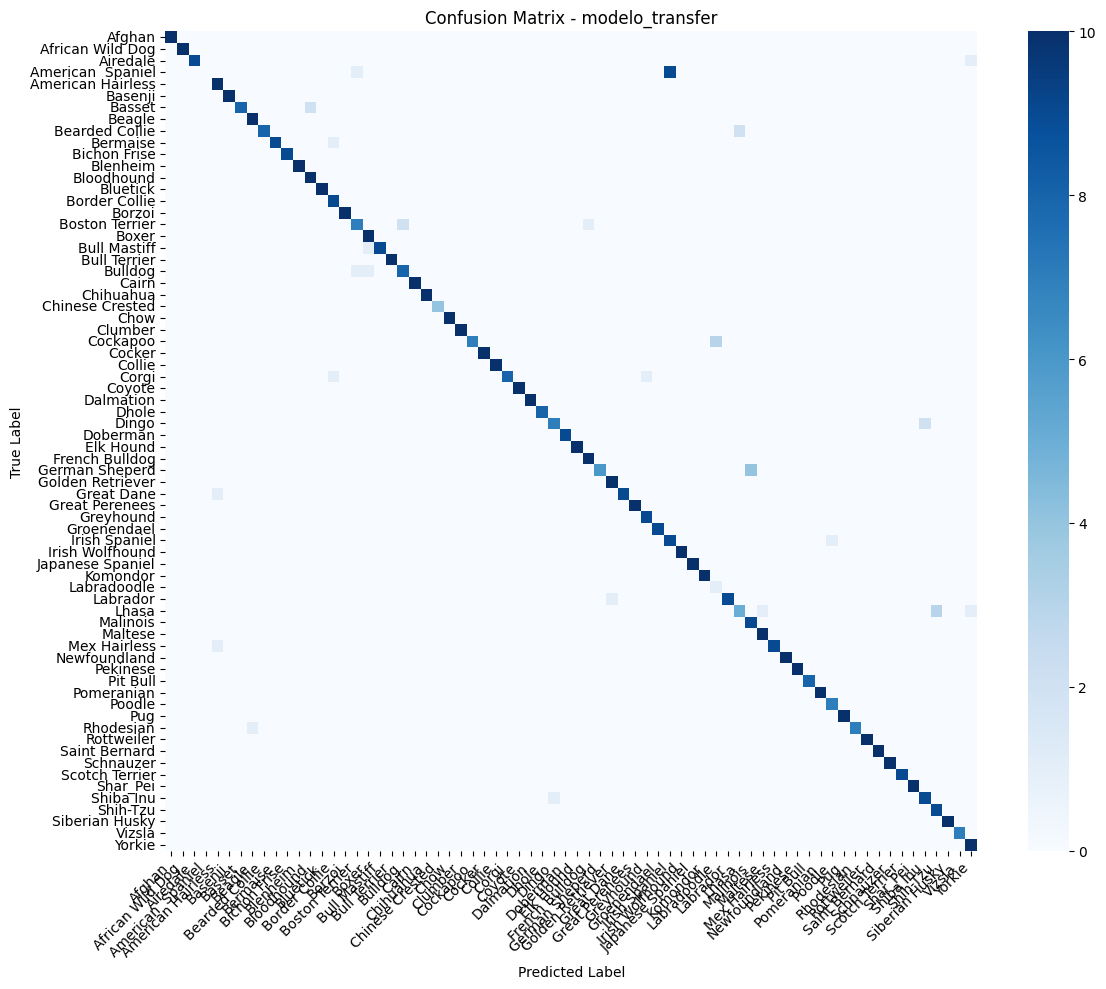

In [ ]:
plot_confusion_matrix(modelo_transfer, val_loader, device, label_encoder, model_name="modelo_transfer")

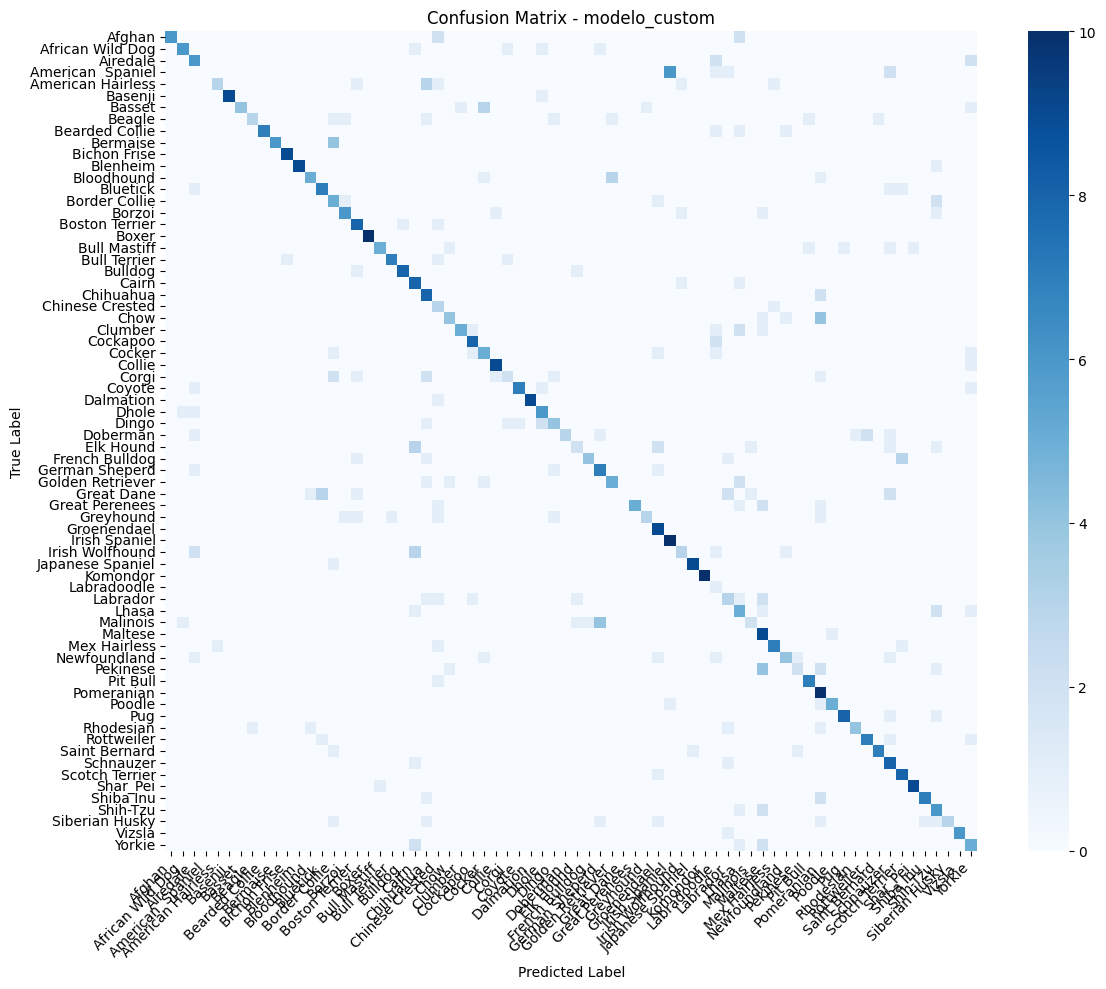

In [ ]:
plot_confusion_matrix(modelo_custom, val_loader, device, label_encoder, model_name="modelo_custom")

El modelo entrenado por transfer learning es mucho mejor para todo practicamente. Capaz que ajustando el custom se logre mejores metricas pero por falta de poder de computo y tiempo voy a utilizar el primero.

American Spaniel sigue estando a pesar de dropearlo (no se la razon, ya probe correrlo varias veces)

## Obtenemos modelos solo con embedding

Para poder realizar el siguiente punto:

Actualice la aplicación de Gradio para que los vectores de características se puedan generar usando tanto el ResNet18 entrenado como su modelo custom.

Es necesario poder "desconectar" el head de las 2 redes, manteniendonos solo con los numeros despues del flatten. Como conocemos la estructura podemos utilizar slices de listas para eliminar lo que no queremos

In [ ]:
custom_embedding = nn.Sequential(*list(modelo_custom.children())[:-4])
transfer_embedding = nn.Sequential(*list(modelo_transfer.children())[:-1])

custom_embedding.to(device)
custom_embedding.eval()

transfer_embedding.to(device)
transfer_embedding.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Creamos 2 colecciones nuevas en chroma para cada modelo
custom_collection = client.create_collection(name="custom_collection")
transfer_collection = client.create_collection(name="transfer_collection")

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [ ]:
for sample in train_dataset:
  path = sample.filepath

  img = PIL.Image.open(path)
  # Convertimos a tensor
  img_tensor = val_transform(img).unsqueeze(0).to(device)

  # aplicamos los modelos
  with torch.no_grad():
    custom_embedding_output = custom_embedding(img_tensor)
    transfer_embedding_output = transfer_embedding(img_tensor)

  # Guardamos en base de datos respectiva
  custom_collection.add(
      documents = [sample.filepath],
      embeddings = [custom_embedding_output.squeeze().tolist()],
      metadatas = [{'label': sample.ground_truth.label}],
      ids = [sample.id]
  )

  transfer_collection.add(
      documents = [sample.filepath],
      embeddings = [transfer_embedding_output.squeeze().tolist()],
      metadatas = [{'label': sample.ground_truth.label}],
      ids = [sample.id]
  )

In [ ]:
# comprimimos las base de datos para luego descargarlas
!zip -r /content/chroma.zip /content/chroma

  adding: content/chroma/ (stored 0%)
  adding: content/chroma/chroma.sqlite3 (deflated 67%)
  adding: content/chroma/e6095458-665d-4ae0-b9ca-79e4b2ea3561/ (stored 0%)
  adding: content/chroma/e6095458-665d-4ae0-b9ca-79e4b2ea3561/index_metadata.pickle (deflated 84%)
  adding: content/chroma/e6095458-665d-4ae0-b9ca-79e4b2ea3561/header.bin (deflated 55%)
  adding: content/chroma/e6095458-665d-4ae0-b9ca-79e4b2ea3561/data_level0.bin (deflated 57%)
  adding: content/chroma/e6095458-665d-4ae0-b9ca-79e4b2ea3561/length.bin (deflated 70%)
  adding: content/chroma/e6095458-665d-4ae0-b9ca-79e4b2ea3561/link_lists.bin (deflated 82%)
  adding: content/chroma/b4825bc3-75f4-4d31-a654-76959d210183/ (stored 0%)
  adding: content/chroma/b4825bc3-75f4-4d31-a654-76959d210183/chroma.sqlite3 (deflated 96%)
  adding: content/chroma/b4825bc3-75f4-4d31-a654-76959d210183/index_metadata.pickle (deflated 84%)
  adding: content/chroma/b4825bc3-75f4-4d31-a654-76959d210183/header.bin (deflated 55%)
  adding: content/

## Actualizacion del Gradio

In [ ]:
def buscar_imagenes_similares(imagen_subida, modelo_seleccionado):
    """
    Función que procesa la imagen subida y busca imágenes similares
    """
    if imagen_subida is None:
        return "Por favor, sube una imagen primero.", []

    try:
        # Seleccionar modelo y colección según la elección del usuario
        if modelo_seleccionado == "Modelo Custom":
            modelo_a_usar = custom_embedding  # Tu modelo custom
            coleccion_a_usar = custom_collection
        else:  # ResNet18 Transfer Learning
            modelo_a_usar = transfer_embedding  # Tu modelo ResNet18
            coleccion_a_usar = transfer_collection

        # Generar embedding de la imagen subida
        img_tensor = val_transform(imagen_subida).unsqueeze(0).to(device)

        with torch.no_grad():
          embed_imagen_subida = modelo_a_usar(img_tensor).squeeze().tolist()

        # Realiza consulta en la colección correspondiente
        results = coleccion_a_usar.query(
            query_embeddings=embed_imagen_subida,
            n_results=10
        )

        # Procesar los resultados para mostrar las imágenes
        imagenes_similares = []

        for result in results['documents'][0]:
            try:
                img = Image.open(result)
                imagenes_similares.append(img)
            except Exception as e:
                print(f"Error cargando imagen: {e}")
                continue

        raza_detectada = voto_mayoritario(results)

        mensaje = f"Búsqueda con {modelo_seleccionado}: Se encontraron {len(imagenes_similares)} imágenes similares"
        return mensaje, imagenes_similares, raza_detectada

    except Exception as e:
        return f"Error procesando la imagen: {str(e)}", []




In [ ]:
# Crear la interfaz con Gradio

with gr.Blocks(title="Búsqueda de Imágenes Similares", theme=gr.themes.Soft()) as demo2:

    gr.Markdown("# 🔍 Búsqueda de Imágenes Similares")
    gr.Markdown("Arrastra o selecciona una imagen para encontrar imágenes similares en la base de datos.")

    with gr.Row():
        with gr.Column(scale=1):
            # Componente para subir imagen
            imagen_input = gr.Image(
                label="Sube tu imagen aquí",
                type="pil",  # Devuelve PIL Image
                height=300
            )

            # Selector de modelo
            modelo_selector = gr.Dropdown(
                choices=["Modelo Custom", "ResNet18 Transfer Learning"],
                value="Modelo Custom",
                label="Selecciona el modelo para la búsqueda",
                info="Elige qué modelo usar para generar los embeddings"
            )

            # Botón para procesar
            buscar_btn = gr.Button("🔍 Buscar Imágenes Similares", variant="primary", size="lg")

        with gr.Column(scale=2):
            # Mensaje de estado
            mensaje_output = gr.Textbox(
                label="Estado",
                interactive=False,
                lines=2
            )

            # Raza detectada por voto mayoritario
            raza_output = gr.Textbox(
                label="Raza Detectada (voto mayoritario)",
                interactive=False
            )

    # Galería para mostrar resultados
    galeria_output = gr.Gallery(
        label="Imágenes Similares Encontradas",
        show_label=True,
        elem_id="galeria",
        columns=5,
        rows=2,
        height="auto"
    )

    # Conectar el botón con la función
    buscar_btn.click(
        fn=buscar_imagenes_similares,
        inputs=[imagen_input, modelo_selector],
        outputs=[mensaje_output, galeria_output, raza_output]
    )

    # También permitir búsqueda automática al subir imagen o cambiar modelo
    imagen_input.change(
        fn=buscar_imagenes_similares,
        inputs=[imagen_input, modelo_selector],
        outputs=[mensaje_output, galeria_output, raza_output]
    )

    modelo_selector.change(
        fn=buscar_imagenes_similares,
        inputs=[imagen_input, modelo_selector],
        outputs=[mensaje_output, galeria_output, raza_output]
    )

demo2.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0a5ce50216f5c50c63.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0a5ce50216f5c50c63.gradio.live


## Calculo NDCG con las 2 nuevas base de datos

Por como fue definida la funcion ndcg anteriormente no es posible utilizarla para esta base de datos, asi que le realizamos una modificacion.

In [ ]:
def evaluar_ndcg_multimodel(val_dataset, custom_collection, transfer_collection, k=10):
    """
    Evalúa el sistema de búsqueda calculando NDCG@k sobre un conjunto de validación
    para las bases de datos del modelo custom y del modelo transfer learning.
    """
    resultados_custom = []
    resultados_transfer = []

    for sample in tqdm(val_dataset, desc="Evaluando NDCG Multimodelo"):
        imagen = sample.filepath
        true_label = sample.ground_truth.label

        try:
            # Cargar imagen como PIL
            img_pil = Image.open(imagen)

            # Convertir a tensor y mover al dispositivo
            img_tensor = val_transform(img_pil).unsqueeze(0).to(device)

            # --- Evaluar modelo Custom ---
            with torch.no_grad():
                embed_custom = custom_embedding(img_tensor).squeeze().tolist()

            # Ejecutar búsqueda en colección custom
            result_custom = custom_collection.query(
                query_embeddings=embed_custom,
                n_results=k
            )

            # Extraer labels de resultados custom
            labels_custom = [meta.get("label", None) for meta in result_custom["metadatas"][0]]

            # Calcular relevancias binarias custom
            relevancias_custom = [1 if label == true_label else 0 for label in labels_custom]

            # Calcular NDCG@k para esta imagen con modelo custom
            ndcg_custom = ndcg_at_k(relevancias_custom, k)
            resultados_custom.append(ndcg_custom)

            # --- Evaluar modelo Transfer Learning ---
            with torch.no_grad():
                embed_transfer = transfer_embedding(img_tensor).squeeze().tolist()

            # Ejecutar búsqueda en colección transfer
            result_transfer = transfer_collection.query(
                query_embeddings=embed_transfer,
                n_results=k
            )

            # Extraer labels de resultados transfer
            labels_transfer = [meta.get("label", None) for meta in result_transfer["metadatas"][0]]

            # Calcular relevancias binarias transfer
            relevancias_transfer = [1 if label == true_label else 0 for label in labels_transfer]

            # Calcular NDCG@k para esta imagen con modelo transfer
            ndcg_transfer = ndcg_at_k(relevancias_transfer, k)
            resultados_transfer.append(ndcg_transfer)


        except Exception as e:
            print(f"Error procesando imagen {imagen}: {e}")
            # Añadir 0 a los resultados si hay error para mantener la longitud consistente
            resultados_custom.append(0.0)
            resultados_transfer.append(0.0)
            continue

    # Métrica final promedio para cada modelo
    promedio_custom = sum(resultados_custom) / len(resultados_custom) if resultados_custom else 0.0
    promedio_transfer = sum(resultados_transfer) / len(resultados_transfer) if resultados_transfer else 0.0

    print(f"\nNDCG@{k} promedio (Modelo Custom): {promedio_custom:.4f}")
    print(f"NDCG@{k} promedio (ResNet18 Transfer Learning): {promedio_transfer:.4f}")

    return (promedio_custom, resultados_custom), (promedio_transfer, resultados_transfer)

# Calcular y mostrar los NDCG para ambas bases de datos vectoriales
ndcg_custom_results, ndcg_transfer_results = evaluar_ndcg_multimodel(val_dataset, custom_collection, transfer_collection, k=10)

print("\nResultados Finales:")
print(f"NDCG@10 Promedio (Modelo Custom): {ndcg_custom_results[0]:.4f}")
print(f"NDCG@10 Promedio (ResNet18 Transfer Learning): {ndcg_transfer_results[0]:.4f}")


Evaluando NDCG Multimodelo: 100%|██████████| 664/664 [01:47<00:00,  6.18it/s]


NDCG@10 promedio (Modelo Custom): 0.6716
NDCG@10 promedio (ResNet18 Transfer Learning): 0.9567

Resultados Finales:
NDCG@10 Promedio (Modelo Custom): 0.6716
NDCG@10 Promedio (ResNet18 Transfer Learning): 0.9567


# Etapa 3

In [ ]:
yolo_model = YOLO('yolo12n.pt') # utilizamos el ultimo modelo de YOLO en su version nano

100%|██████████| 5.34M/5.34M [00:00<00:00, 44.8MB/s]


In [ ]:
def yolo_predict(image_path, yolo_model, classifier_model, label_encoder, transform, device):
    # Cargamos la imagen con PIL
    img = Image.open(image_path).convert('RGB')

    # Obtenemos las bounding box llamando a yolo
    bounding_boxes = yolo_model(img)

    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default(40)

    # Iteramos por las detecciones
    for i, box in enumerate(bounding_boxes[0].boxes.xyxy):
        if int(bounding_boxes[0].boxes.cls[i]) == 16:  # Clase 16 = dog, podemos cambiar eso si queremos otras detecciones
            x1, y1, x2, y2 = map(int, box.tolist())

            # recortamos la imagen
            cropped_img = img.crop((x1, y1, x2, y2))

            # utilizamos la transformacion para tenerla en 224x224 para nuestro modelo
            img_tensor = transform(cropped_img).unsqueeze(0).to(device)

            # Clasifica al perro
            with torch.no_grad():
                output = classifier_model(img_tensor)
            _, predicted = torch.max(output, 1)
            predicted = predicted.item()
            predicted = predicted - 1 if predicted > 3 else predicted # fix porque el encoder tiene American Spaniel que fue borrado
            predicted_label = label_encoder.classes_[predicted]

            # dibuja su bounding box y label
            draw.rectangle([x1, y1, x2, y2], outline="green", width=3)
            draw.text((x1, y1 - 40), predicted_label, fill="green", font=font)

    return img


## Testeo

In [ ]:
image_path = '/content/dobermanrotw.jpg'
predicted = yolo_predict(image_path, yolo_model, modelo_transfer, label_encoder, val_transform, device)


0: 640x448 2 dogs, 57.3ms
Speed: 3.1ms preprocess, 57.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


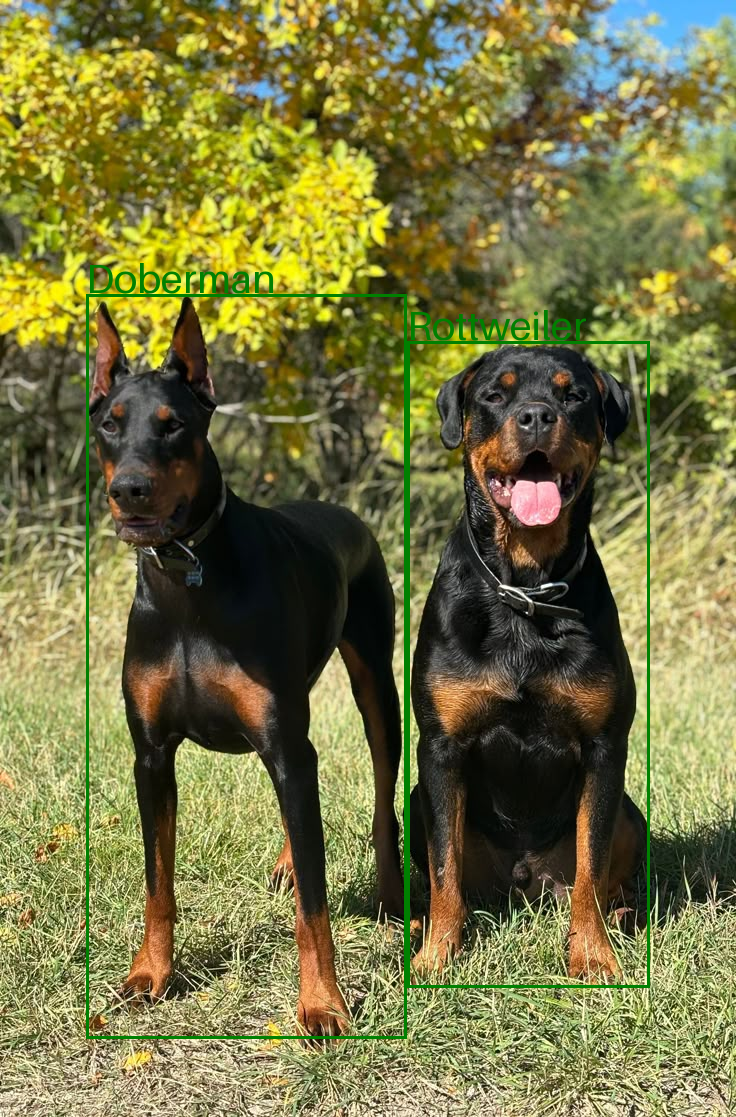

In [ ]:
predicted

In [ ]:
image_path = 'corgi.webp'
predicted = yolo_predict(image_path, yolo_model, modelo_transfer, label_encoder, val_transform, device)
predicted


0: 640x480 3 dogs, 41.4ms
Speed: 3.9ms preprocess, 41.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)



0: 448x640 1 dog, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


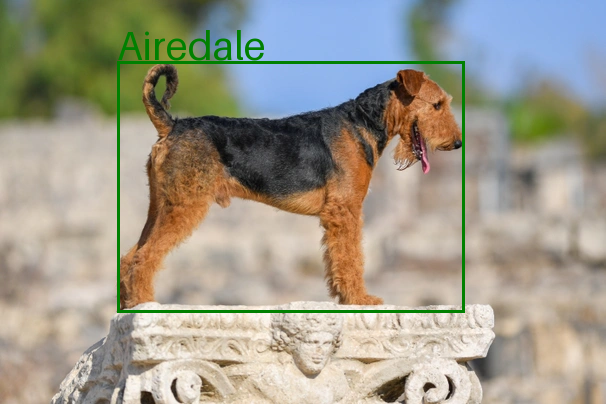

In [ ]:
image_path = 'airedale.webp'
predicted = yolo_predict(image_path, yolo_model, modelo_transfer, label_encoder, val_transform, device)
predicted


0: 448x640 (no detections), 29.3ms
Speed: 3.8ms preprocess, 29.3ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


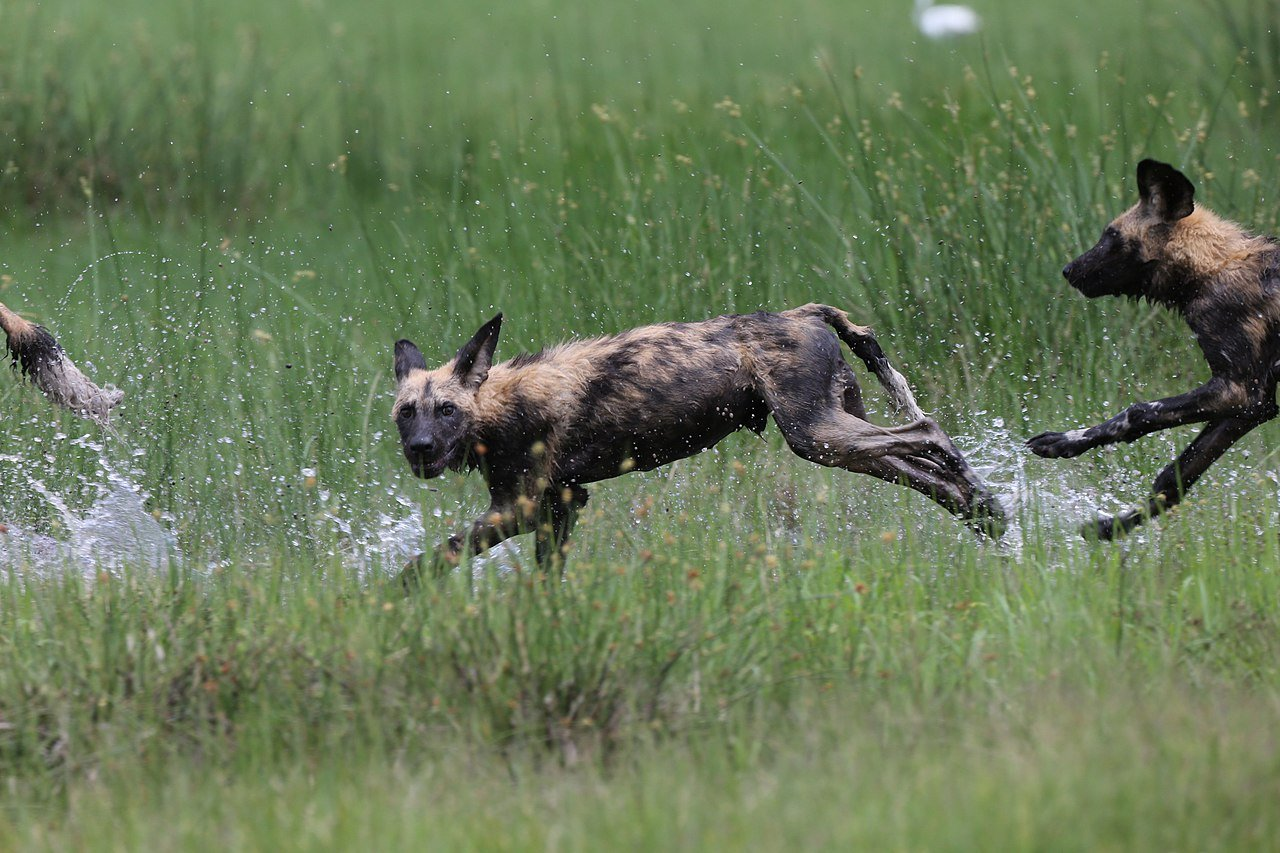

In [ ]:
image_path = 'africanwildog.jpg'
predicted = yolo_predict(image_path, yolo_model, modelo_transfer, label_encoder, val_transform, device)
predicted

No logra YOLO detectar al perro


0: 448x640 2 dogs, 27.6ms
Speed: 3.2ms preprocess, 27.6ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


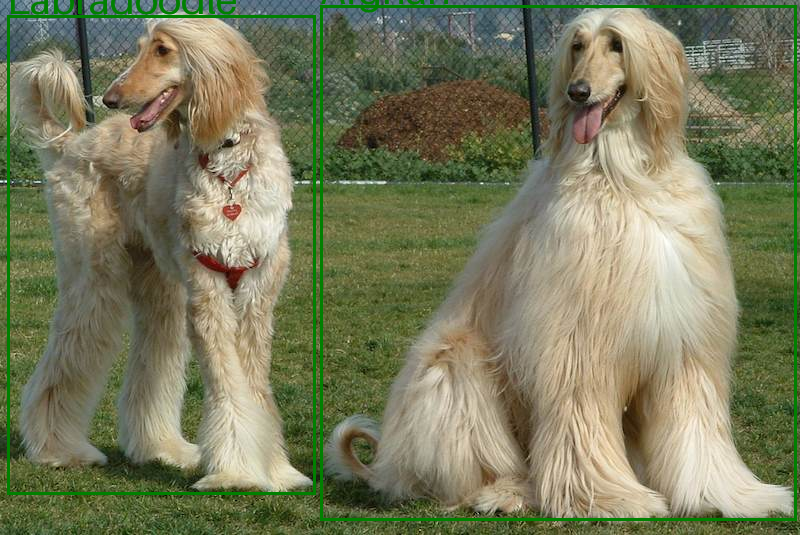

In [ ]:
image_path = 'afghan.jpg'
predicted = yolo_predict(image_path, yolo_model, modelo_transfer, label_encoder, val_transform, device)
predicted

Vemos que se recorta el label si esta muy cerca del borde. Sera arreglado en la aplicacion final

## Metricas

In [ ]:
#!unzip pics.zip

In [88]:
def load_yolo_annotations(dataset_path):
    """
    Load YOLO format annotations from dataset
    Returns: dict with image_id -> list of annotations
    """
    images_path = os.path.join(dataset_path, 'images')
    labels_path = os.path.join(dataset_path, 'labels')
    classes_path = os.path.join(dataset_path, 'classes.txt')

    # Load class names
    with open(classes_path, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]

    annotations = {}

    # Get all image files
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]

    for img_file in image_files:
        img_path = os.path.join(images_path, img_file)
        img_name = os.path.splitext(img_file)[0]
        label_file = os.path.join(labels_path, f"{img_name}.txt")

        # Get image dimensions
        with Image.open(img_path) as img:
            img_width, img_height = img.size

        annotations[img_file] = {
            'width': img_width,
            'height': img_height,
            'boxes': []
        }

        # Load annotations if label file exists
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])

                        # Convert from YOLO format (normalized) to absolute coordinates
                        x1 = int((x_center - width/2) * img_width)
                        y1 = int((y_center - height/2) * img_height)
                        x2 = int((x_center + width/2) * img_width)
                        y2 = int((y_center + height/2) * img_height)

                        annotations[img_file]['boxes'].append({
                            'class_id': class_id,
                            'bbox': [x1, y1, x2, y2],
                            'class_name': class_names[class_id] if class_id < len(class_names) else f"class_{class_id}"
                        })

    return annotations, class_names

def yolo_predict_for_eval(image_path, yolo_model, classifier_model, label_encoder, transform, device, confidence_threshold=0.5):
    """
    Modified prediction function that returns detections with confidence scores
    """
    img = Image.open(image_path).convert('RGB')
    bounding_boxes = yolo_model(img)

    detections = []

    for i, box in enumerate(bounding_boxes[0].boxes.xyxy):
        confidence = float(bounding_boxes[0].boxes.conf[i])
        yolo_class = int(bounding_boxes[0].boxes.cls[i])

        if yolo_class == 16 and confidence >= confidence_threshold:  # Dog class
            x1, y1, x2, y2 = map(int, box.tolist())

            # Crop and classify
            cropped_img = img.crop((x1, y1, x2, y2))
            img_tensor = transform(cropped_img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = classifier_model(img_tensor)
                probs = torch.softmax(output, dim=1)
                max_prob, predicted = torch.max(probs, 1)

                predicted = predicted.item()
                predicted = predicted - 1 if predicted > 3 else predicted

                if 0 <= predicted < len(label_encoder.classes_):
                    predicted_label = label_encoder.classes_[predicted]
                    classification_confidence = float(max_prob.item())

                    # Combined confidence (YOLO detection * classification)
                    final_confidence = confidence * classification_confidence

                    detections.append({
                        'bbox': [x1, y1, x2, y2],
                        'confidence': final_confidence,
                        'class_name': predicted_label,
                        'yolo_confidence': confidence,
                        'classification_confidence': classification_confidence
                    })

    return detections

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) of two bounding boxes
    box format: [x1, y1, x2, y2]
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    if x2_inter <= x1_inter or y2_inter <= y1_inter:
        return 0.0

    inter_area = (x2_inter - x1_inter) * (y2_inter - y1_inter)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0.0

def calculate_ap_single_class(gt_boxes, pred_boxes, iou_threshold):
    """
    Calculate Average Precision for a single class at a specific IoU threshold
    """
    if len(gt_boxes) == 0:
        return 0.0 if len(pred_boxes) == 0 else 0.0

    if len(pred_boxes) == 0:
        return 0.0

    # Sort predictions by confidence (descending)
    pred_boxes = sorted(pred_boxes, key=lambda x: x['confidence'], reverse=True)

    # Initialize arrays
    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))

    # Keep track of which ground truth boxes have been matched
    gt_matched = [False] * len(gt_boxes)

    # For each prediction
    for pred_idx, pred in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1

        # Find best matching ground truth box
        for gt_idx, gt in enumerate(gt_boxes):
            if gt_matched[gt_idx]:
                continue

            iou = calculate_iou(pred['bbox'], gt['bbox'])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx

        # Check if prediction is correct
        if best_iou >= iou_threshold and best_gt_idx != -1:
            tp[pred_idx] = 1
            gt_matched[best_gt_idx] = True
        else:
            fp[pred_idx] = 1

    # Calculate precision and recall
    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)

    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)
    recall = tp_cumsum / len(gt_boxes)

    # Calculate AP using 11-point interpolation
    ap = 0
    for t in np.arange(0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11

    return ap

def calculate_precision_recall_f1_iou(gt_by_class, pred_by_class, iou_threshold=0.5):
    """
    Calculate overall precision, recall, F1, and mean IoU across all classes
    """
    all_tp = 0
    all_fp = 0
    all_fn = 0
    all_ious = []

    # Get all unique classes
    all_classes = set(list(gt_by_class.keys()) + list(pred_by_class.keys()))

    for class_name in all_classes:
        gt_boxes = gt_by_class[class_name]
        pred_boxes = pred_by_class[class_name]

        if len(gt_boxes) == 0:
            all_fp += len(pred_boxes)
            continue

        if len(pred_boxes) == 0:
            all_fn += len(gt_boxes)
            continue

        # Sort predictions by confidence
        pred_boxes = sorted(pred_boxes, key=lambda x: x['confidence'], reverse=True)

        # Track matched ground truth boxes
        gt_matched = [False] * len(gt_boxes)

        for pred in pred_boxes:
            best_iou = 0
            best_gt_idx = -1

            # Find best matching ground truth
            for gt_idx, gt in enumerate(gt_boxes):
                if gt_matched[gt_idx]:
                    continue

                iou = calculate_iou(pred['bbox'], gt['bbox'])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx

            # Check if match is good enough
            if best_iou >= iou_threshold and best_gt_idx != -1:
                all_tp += 1
                gt_matched[best_gt_idx] = True
                all_ious.append(best_iou)
            else:
                all_fp += 1

        # Count unmatched ground truth as false negatives
        all_fn += sum(1 for matched in gt_matched if not matched)

    # Calculate metrics
    precision = all_tp / (all_tp + all_fp + 1e-8)
    recall = all_tp / (all_tp + all_fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    mean_iou = np.mean(all_ious) if all_ious else 0.0

    return precision, recall, f1, mean_iou, all_tp, all_fp, all_fn

def evaluate_model(dataset_path, yolo_model, classifier_model, label_encoder, transform, device, confidence_threshold=0.5):
    """
    Evaluate model and calculate mAP 0.5:0.95, plus precision, recall, F1, and IoU
    """
    print("Loading annotations...")
    annotations, class_names = load_yolo_annotations(dataset_path)

    # Group ground truth and predictions by class
    gt_by_class = defaultdict(list)
    pred_by_class = defaultdict(list)

    print(f"Processing {len(annotations)} images...")

    for img_file, ann_data in annotations.items():
        img_path = os.path.join(dataset_path, 'images', img_file)

        if not os.path.exists(img_path):
            continue

        print(f"Processing {img_file}...")

        # Get ground truth boxes
        for box_data in ann_data['boxes']:
            gt_by_class[box_data['class_name']].append({
                'bbox': box_data['bbox'],
                'image_id': img_file
            })

        # Get predictions
        try:
            detections = yolo_predict_for_eval(
                img_path, yolo_model, classifier_model,
                label_encoder, transform, device, confidence_threshold
            )

            for det in detections:
                pred_by_class[det['class_name']].append({
                    'bbox': det['bbox'],
                    'confidence': det['confidence'],
                    'image_id': img_file
                })

        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            continue

    # Calculate precision, recall, F1, IoU at IoU 0.5
    print("\nCalculating precision, recall, F1, and IoU...")
    precision, recall, f1, mean_iou, tp, fp, fn = calculate_precision_recall_f1_iou(
        gt_by_class, pred_by_class, iou_threshold=0.5
    )

    # Calculate mAP for different IoU thresholds
    iou_thresholds = np.arange(0.5, 1.0, 0.05)  # 0.5:0.95 with step 0.05

    results = {}
    all_aps = []

    print(f"\nCalculating mAP for {len(iou_thresholds)} IoU thresholds...")

    for iou_thresh in iou_thresholds:
        class_aps = []

        for class_name in set(list(gt_by_class.keys()) + list(pred_by_class.keys())):
            gt_boxes = gt_by_class[class_name]
            pred_boxes = pred_by_class[class_name]

            ap = calculate_ap_single_class(gt_boxes, pred_boxes, iou_thresh)
            class_aps.append(ap)

            if iou_thresh == 0.5:  # Store detailed results for IoU 0.5
                results[f"AP_{class_name}@0.5"] = ap

        mean_ap = np.mean(class_aps) if class_aps else 0.0
        all_aps.append(mean_ap)
        results[f"mAP@{iou_thresh:.2f}"] = mean_ap

    # Calculate final mAP 0.5:0.95
    map_50_95 = np.mean(all_aps)
    results["mAP@0.5:0.95"] = map_50_95
    results["mAP@0.5"] = results.get("mAP@0.50", 0.0)

    # Add precision, recall, F1, IoU metrics
    results["precision@0.5"] = precision
    results["recall@0.5"] = recall
    results["f1@0.5"] = f1
    results["mean_iou@0.5"] = mean_iou
    results["true_positives"] = tp
    results["false_positives"] = fp
    results["false_negatives"] = fn

    return results

def print_evaluation_results(results):
    """
    Print evaluation results in a formatted way
    """
    print("\n" + "="*60)
    print("EVALUATION RESULTS")
    print("="*60)

    # Main metrics
    print(f"mAP@0.5:0.95: {results['mAP@0.5:0.95']:.4f}")
    print(f"mAP@0.5:     {results['mAP@0.5']:.4f}")

    # Additional metrics at IoU 0.5
    print(f"\n📊 Metrics at IoU 0.5:")
    print(f"Precision:    {results['precision@0.5']:.4f}")
    print(f"Recall:       {results['recall@0.5']:.4f}")
    print(f"F1-Score:     {results['f1@0.5']:.4f}")
    print(f"Mean IoU:     {results['mean_iou@0.5']:.4f}")

    # Detection counts
    print(f"\n🔢 Detection Counts:")
    print(f"True Positives:  {results['true_positives']}")
    print(f"False Positives: {results['false_positives']}")
    print(f"False Negatives: {results['false_negatives']}")

    print("\nPer-class AP@0.5:")
    for key, value in results.items():
        if key.startswith("AP_") and key.endswith("@0.5"):
            class_name = key.replace("AP_", "").replace("@0.5", "")
            print(f"  {class_name}: {value:.4f}")

    print("\nDetailed mAP per IoU threshold:")
    for key, value in results.items():
        if key.startswith("mAP@") and not key in ["mAP@0.5:0.95", "mAP@0.5"]:
            print(f"  {key}: {value:.4f}")


In [84]:
from collections import defaultdict
import json


In [81]:
dataset_path = '/content/pics/yololabels/'
confidence_threshold = 0.5

In [87]:
results = evaluate_model(
    dataset_path=dataset_path,
    yolo_model=yolo_model,  # Your YOLO model
    classifier_model=modelo_transfer,  # Your ResNet model
    label_encoder=label_encoder,  # Your label encoder
    transform=val_transform,  # Your transform
    device=device,  # Your device
    confidence_threshold=confidence_threshold
)

print_evaluation_results(results)

Loading annotations...
Processing 10 images...
Processing yonki.jpg...

0: 448x640 1 person, 1 dog, 311.9ms
Speed: 3.6ms preprocess, 311.9ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)
Processing 2scocht.webp...

0: 640x480 3 dogs, 1 chair, 313.8ms
Speed: 4.1ms preprocess, 313.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
Processing rotw2.jpg...

0: 448x640 3 dogs, 3 chairs, 190.2ms
Speed: 3.0ms preprocess, 190.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Processing labrador.webp...

0: 640x512 1 dog, 2 keyboards, 224.2ms
Speed: 3.1ms preprocess, 224.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)
Processing basset.webp...

0: 640x480 1 bench, 1 dog, 206.6ms
Speed: 3.7ms preprocess, 206.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
Processing scocht.webp...

0: 640x480 1 dog, 203.1ms
Speed: 3.2ms preprocess, 203.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 

## Actualizacion de aplicacion

In [ ]:
def procesar_imagen_completa(imagen_subida):
    """
    Función que procesa la imagen con YOLO y clasificador
    """
    if imagen_subida is None:
        return "Por favor, sube una imagen primero.", None

    try:
        # Guardar temporalmente la imagen subida
        import tempfile
        with tempfile.NamedTemporaryFile(delete=False, suffix='.jpg') as tmp_file:
            imagen_subida.save(tmp_file.name)
            temp_path = tmp_file.name

        # Aplicar el pipeline completo usando la función yolo_predict
        imagen_procesada = yolo_predict(
            image_path=temp_path,
            yolo_model=yolo_model,
            classifier_model=modelo_transfer,  # El mejor modelo de la Etapa 2
            label_encoder=label_encoder,
            transform=val_transform,
            device=device
        )

        # Limpiar archivo temporal
        os.unlink(temp_path)

        mensaje = "✅ Procesamiento completado: Se detectaron perros y se clasificaron sus razas"
        return mensaje, imagen_procesada

    except Exception as e:
        return f"❌ Error procesando la imagen: {str(e)}", None

# Crear la interfaz con Gradio para el pipeline completo
with gr.Blocks(title="Pipeline YOLO + Clasificador de Razas", theme=gr.themes.Soft()) as demo3:

    gr.Markdown("# 🐕 Pipeline Completo: Detección y Clasificación de Razas de Perros")
    gr.Markdown("""
    **Flujo de trabajo:**
    1. Sube una imagen que contenga uno o más perros
    2. YOLO detecta automáticamente todos los perros en la imagen
    3. Para cada perro detectado, se recorta la imagen
    4. El clasificador predice la raza de cada perro
    5. Se muestra la imagen original con bounding boxes y etiquetas de razas
    """)

    with gr.Row():
        with gr.Column(scale=1):
            # Componente para subir imagen
            imagen_input = gr.Image(
                label="📤 Sube una imagen con perros",
                type="pil",
                height=400
            )

            # Botón para procesar
            procesar_btn = gr.Button(
                "🚀 Detectar y Clasificar Perros",
                variant="primary",
                size="lg"
            )

        with gr.Column(scale=1):
            # Mensaje de estado
            mensaje_output = gr.Textbox(
                label="📊 Estado del Procesamiento",
                interactive=False,
                lines=2
            )

            # Imagen resultado
            imagen_resultado = gr.Image(
                label="🎯 Resultado: Imagen con Detecciones y Clasificaciones",
                height=400
            )

    # Conectar el botón con la función
    procesar_btn.click(
        fn=procesar_imagen_completa,
        inputs=[imagen_input],
        outputs=[mensaje_output, imagen_resultado]
    )

    # También permitir procesamiento automático al subir imagen
    imagen_input.change(
        fn=procesar_imagen_completa,
        inputs=[imagen_input],
        outputs=[mensaje_output, imagen_resultado]
    )

In [ ]:
demo3.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cfdc2e6e46305214d5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Etapa 4

## Optimizacion de modelo

In [ ]:
yolo_model.export(format="ONNX")

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv12n summary (fused): 159 layers, 2,590,824 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from 'yolo12n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.3 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 4.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 11.7s, saved as 'yolo12n.onnx' (10.2 MB)

Export complete (14.2s)
Results saved to /content
Predict:         yolo predict task=detect model=yolo12n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolo12n.o

'yolo12n.onnx'

In [ ]:
onnx_yolo_model = YOLO('yolo12n.onnx')

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [ ]:
image_path = 'corgi.webp'
img = Image.open(image_path).convert('RGB')

In [ ]:
import time
iter = 1000

start_time = time.perf_counter()

for i in range(iter):
  results = onnx_yolo_model(img, verbose = False)
  inference_total = results[0].speed['inference']
  preprocess_total = results[0].speed['preprocess']
  postprocess_total = results[0].speed['postprocess']

elapsed_time = time.perf_counter() - start_time

# calculamos tiempo promedio
average_time = inference_total / iter
print("Average inference time:", average_time, "ms")
print("Average preprocess time:", preprocess_total / iter, "ms")
print("Average postprocess time:", postprocess_total / iter, "ms")
print("Average total process time per frame:", elapsed_time / iter * 1000, "ms")

Average inference time: 0.010166214000491891 ms
Average preprocess time: 0.0039760630006639985 ms
Average postprocess time: 0.002385044999755337 ms
Average total process time per frame: 23.417404460000398 ms


In [ ]:
start_time = time.perf_counter()

for i in range(iter):
  results = yolo_model(img, verbose = False)
  inference_total = results[0].speed['inference']
  preprocess_total = results[0].speed['preprocess']
  postprocess_total = results[0].speed['postprocess']

elapsed_time = time.perf_counter() - start_time

# calculamos tiempo promedio
average_time = inference_total / iter
print("Average inference time:", average_time, "ms")
print("Average preprocess time:", preprocess_total / iter, "ms")
print("Average postprocess time:", postprocess_total / iter, "ms")
print("Average total process time per frame:", elapsed_time / iter * 1000, "ms")

Average inference time: 0.013611733998914133 ms
Average preprocess time: 0.002309732999492553 ms
Average postprocess time: 0.0012685530000453582 ms
Average total process time per frame: 40.82208677499875 ms


Para mi sorpresa, el modelo llevado a ONNX es casi 100% mas rapido. Pense que los modelos descargados ya venian con cierta optimizacion pero es clave poder realizar estas despues de descargarlo para poder mejorar el consumo de recursos de la computadora.